# Endpoint Performance: Client Access

The goal of this experiment is to understand the limit of what a single endpoint can handle within local system. We test this by launching a bunch of clients/workers on the system with the endpoint that make `get`/`set` requests to the endpoint. Note: that this does not test any of the endpoint-to-endpoint p2p capabilities

## Instructions

### Setup

1. Clone and install https://github.com/proxystore/proxystore-benchmarks
   ```bash
   $ git clone git@github.com:proxystore/proxystore-benchmarks.git
   $ cd proxystore-benchmarks
   $ virtualenv venv
   $ . venv/bin/activate
   $ pip install -e .
   ```
2. Configure a ProxyStore endpoint
   ```bash
   $ proxystore-endpoint configure psbench
   $ proxystore-endpoint start psbench
   ```
   Note: endpoint logs will still be written to `~/.local/share/proxystore/psbench`, and the endpoint should be stopped after benchmarking is finished.
   
### Run

```bash
$ python -m psbench.benchmarks.endpoint_qps \
    {ENDPOINT UUID} \
    --route SET \
    --queries 1000 \
    --workers 4 \
    --payload-size 1000
```

### Notes:
- The provided results were collected on a Perlmutter CPU node (2 AMD EPYC 7763 [64 cores/socket, 2 threads/core], 512 GB RAM)
  ```bash
  $ salloc --qos interactive --constraint cpu --account={PROJECT-ID} -t 2:00:00
  ```

In [1]:
%matplotlib inline

from __future__ import annotations

import math

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.markers as markers
import pandas
import numpy

In [2]:
ROUTE_COLUMN = 'route'
PAYLOAD_COLUMN = 'payload_size_bytes'
WORKERS_COLUMN = 'workers'
LATENCY_AVG_COLUMN = 'avg_latency_ms'
LATENCY_STDEV_COLUMN = 'stdev_latency_ms'

def load(filepath: str) -> pandas.DataFrame:
    return pandas.read_csv(filepath)

In [3]:
DATA = load('data/3-endpoint-performance-client-access/perlmutter-cpu-node-endpoint-times-local.csv')
DATA.head()

,route,payload_size_bytes,total_queries,sleep_seconds,workers,min_worker_elapsed_time_ms,max_worker_elapsed_time_ms,avg_worker_elapsed_time_ms,stdev_worker_elapsed_time_ms,min_latency_ms,max_latency_ms,avg_latency_ms,stdev_latency_ms,qps
0,GET,1000,1000,0,1,1679.874669,1679.874669,1679.874669,0.0,1.639994,3.290258,1.679875,0.072926,595.282504
1,GET,10000,1000,0,1,1678.731692,1678.731692,1678.731692,0.0,1.640305,2.235342,1.678732,0.038487,595.687807
2,GET,100000,1000,0,1,1733.743772,1733.743772,1733.743772,0.0,1.686854,2.352939,1.733744,0.037188,576.786499
3,GET,1000000,1000,0,1,1949.055177,1949.055177,1949.055177,0.0,1.877241,3.210314,1.949055,0.056384,513.069107
4,GET,10000000,1000,0,1,5328.789265,5328.789265,5328.789265,0.0,5.088487,9.162526,5.328789,0.196930,187.659889


In [4]:
def rows_matching_column_value(data: pandas.DataFrame, column: str, value) -> pandas.DataFrame:
    return data.loc[data[column] == value]

def extract_series(data: pandas.DataFrame, route: str, payload_size: int) -> dict[str, list[str]]:
    data = rows_matching_column_value(data, ROUTE_COLUMN, route)
    data = rows_matching_column_value(data, PAYLOAD_COLUMN, payload_size)
    return {
        'workers': list(data[WORKERS_COLUMN]),
        'avg_latency': list(data[LATENCY_AVG_COLUMN]),
        'stdev_latency': list(data[LATENCY_STDEV_COLUMN]),
    }
    
def extract(data: pandas.DataFrame, route: str) -> dict[str, dict[str, list[str]]]:
    payloads = data[PAYLOAD_COLUMN].unique()
    return {payload: extract_series(data, route, payload) for payload in payloads}

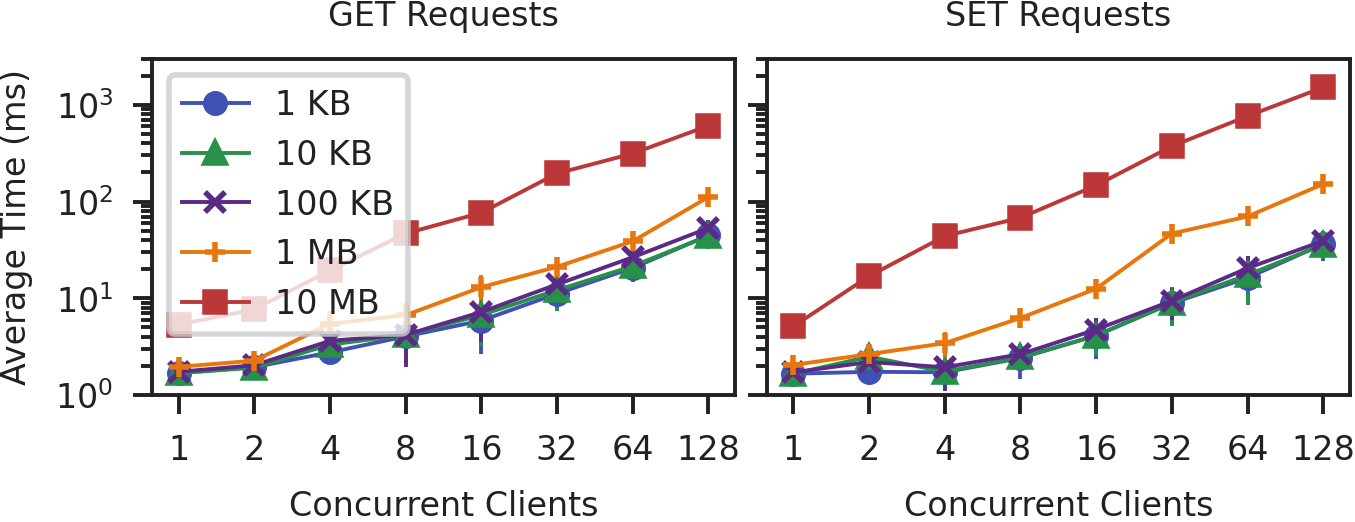

In [7]:
GET_DATA = extract(DATA, 'GET')
SET_DATA = extract(DATA, 'SET')

MARKERS = ('o', '^', 'x', '+', 's', 'P')


payload_labels = ['1 KB', '10 KB', '100 KB', '1 MB', '10 MB']

fig, axs = plt.subplots(1, 2, sharey=True)

for data, ax in zip((GET_DATA, SET_DATA), axs):
    ax.set_yscale('log', base=10)
    ax.set_xscale('log', base=2)

    for i, (payload, series) in enumerate(data.items()):
        # ax.plot(series['workers'], series['avg_latency'], marker=MARKERS[i], label=payload)
        ax.errorbar(series['workers'], series['avg_latency'], series['stdev_latency'], marker=MARKERS[i], label=payload)

axs[0].set_xlabel('Concurrent Clients')
axs[1].set_xlabel('Concurrent Clients')
axs[0].set_ylabel('Average Time (ms)')
axs[0].set_title('GET Requests')
axs[1].set_title('SET Requests')

axs[0].set_xticks([1, 2, 4, 8, 16, 32, 64, 128])
axs[1].set_xticks([1, 2, 4, 8, 16, 32, 64, 128])
axs[0].set_ylim([1, 3000])

# Use integer x labels instead of powers of 2
axs[0].get_xaxis().set_major_formatter(mticker.FormatStrFormatter('%.0f'))
axs[1].get_xaxis().set_major_formatter(mticker.FormatStrFormatter('%.0f'))

handles, labels = axs[0].get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
axs[0].legend(handles, payload_labels, loc='upper left')

fig.tight_layout(h_pad=.5, w_pad=0.75)

fig.set_size_inches(3.35, 1.0)
plt.savefig('figures/endpoint-times-local.pdf', pad_inches=0.05)